# GEOG5990M Final Assignment (Template)

Student ID number: 201787989

## Introduction
The relationship between topography and vegetation health is a crucial aspect of environmental science, influencing ecological stability, hydrological processes, and biodiversity. This project integrates Digital Elevation Model (DEM) and Normalized Difference Vegetation Index (NDVI) data to analyze how terrain features such as slope and elevation impact vegetation health within a selected region. Using advanced GIS techniques and remote sensing data, the study aims to provide a comprehensive understanding of the spatial and non-spatial dynamics affecting vegetation. The insights gained from this analysis can inform environmental management practices, urban planning, and sustainable agricultural development. By leveraging open-source geospatial data and robust analytical methods, this research contributes valuable knowledge to the field, supporting data-driven decision-making for ecological conservation and resource management<a href="#ref1">[1]</a><a href="#ref2">[2]</a>.

In [1]:
# read in required packages
import arcpy
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

This is an example block of mardown text I want to reference <a href="#ref1">[1]</a>. I might need to add some more citations <a href="#ref2">[2]</a><a href="#ref2">[3]</a>

## Data Sources

The geographic data used in this analysis includes multiple datasets, each chosen for its relevance and quality:

1. **Leeds.shp**:
This shapefile, sourced from GEOG5022_web_services_data, initially covered a large area which resulted in slow code execution and poor visualization quality. To address this, a specific subset of the data was selected using `select.shp`, focusing on regions where the 'code' column contains LS1, LS2, and LS3. This subset provides a more manageable and focused study area, improving processing speed and visualization clarity.

2. **DEM.tif**:
The Digital Elevation Model (DEM) data, sourced from OS Terrain 50, was obtained through EDINA’s online DigiMap service. This dataset provides detailed elevation information necessary for calculating slope and understanding the topographic variations within the study area.

3. **NDVI.tif**:
The NDVI data is derived from Landsat 8/9 OLI imagery, covering the period from January 4, 2010, to April 30, 2024, sourced from EarthExplorer USGS. NDVI (Normalized Difference Vegetation Index) is a critical indicator of vegetation health, calculated using the red and near-infrared (NIR) bands of Landsat 8/9 OLI:
    **Band 4 (Red)**: Wavelength range of 0.64 - 0.67 µm
    **Band 5 (Near Infrared - NIR)**: Wavelength range of 0.85 - 0.88 µm
  - The NDVI formula is:
    NDVI=NIR−Red / NIR+Red
  - Given the large size of remote sensing data, the NDVI images required for subsequent analysis were precomputed to avoid long response times when submitting the project. The precomputed image, named `NDVI.tif`, will be used in the analysis, and the code demonstrating the preprocessing steps will be provided.

Code cell:
#### Open the Landsat 8/9 Red and NIR bands as separate datasets</a><a href="#ref6">[6]</a>
- with rasterio.open('LC08_L1TP_123032_20100104_20240430_02_T1_B4.tif') as red_band:
    - red = red_band.read(1).astype('float32')
- with rasterio.open('LC08_L1TP_123032_20100104_20240430_02_T1_B5.tif') as nir_band:
    - nir = nir_band.read(1).astype('float32')
#### Calculate NDVI
- ndvi = (nir - red) / (nir + red)


By using these high-quality and well-documented datasets, the project ensures robust and reliable analysis, focusing on the specific geographic area of Leeds and leveraging the detailed topographic and vegetation health information provided by the DEM and NDVI data respectively.

## Data Preprocessing

In this section, I will detail the steps taken to preprocess the data for subsequent analysis. The preprocessing workflow includes clipping, reprojection, and the extraction of relevant attributes from DEM datasets. These data processing steps ensure the feasibility and accuracy of subsequent spatial analyses, and organizing the results into appropriate folders facilitates categorization and retrieval.

### Steps
1. **Setting Up the Environment**
2. **Clipping the Data**
3. **Reprojecting the Raster Data**
4. **Extracting Slope Data**
5. **Spatial Analysis**

These steps ensure that the data is well-prepared for analysis, allowing us to derive meaningful insights from the spatial relationships between topographic attributes and vegetation health.

In [3]:
# Clipping
# Set workspace
arcpy.env.workspace = r"C:\Users\86153\Desktop\Final_Project\Py"

# Set the clipping extent
shp_file = r"C:\Users\86153\Desktop\Final_Project\GEOG5022_web_services_data\select.shp"  
# Output folder path
output_folder = r"C:\Users\86153\Desktop\Final_Project\out_tif"

# Ensure the output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Get the list of .tif files to be clipped
tif_files = arcpy.ListFiles("*.tif")

# Perform the clipping
for tif_file in tif_files:
    input_raster = os.path.join(arcpy.env.workspace, tif_file)
    output_raster = os.path.join(output_folder, tif_file)
    
    # Execute mask extraction operation
    out_extract_by_mask = arcpy.sa.ExtractByMask(input_raster, shp_file)

    # Save the clipped raster data
    out_extract_by_mask.save(output_raster)
print("{0} clipping completed!".format(output_raster))

C:\Users\86153\Desktop\Final_Project\out_tif\NDVI.tif clipping completed!


In [4]:
# Reproject the raster to match the coordinate system used for analysis or to align with other spatial data
# Input raster file path
input_raster = r"C:\Users\86153\Desktop\Final_Project\out_tif\DEM.tif"

# Output raster file path
output_raster = r"C:\Users\86153\Desktop\Final_Project\out_tif\DEM_ty.tif"

# Target spatial reference (projection information)
target_sr = arcpy.SpatialReference("WGS 1984 UTM Zone 30N")  # Example projection is WGS 1984 UTM Zone 30N

# Execute raster reprojection
arcpy.management.ProjectRaster(input_raster, output_raster, target_sr)
print("Reprojection completed!")

Reprojection completed!


In [5]:
# Zone division and profile line generation
# Set environment
arcpy.env.workspace = r"C:\Users\86153\Desktop\Final_Project"
arcpy.env.overwriteOutput = True

# Input DEM file path
dem_path = r"C:\Users\86153\Desktop\Final_Project\out_tif\DEM_ty.tif"

# Create a folder to save results
output_folder = r"C:\Users\86153\Desktop\Final_Project\output_folder"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
print("Folder creation completed")

# Spatial Analyst tool - Hydrology analysis - Fill sinks
# Use the Fill tool from Spatial Analyst to remove sinks (depressions) in the DEM. This step is crucial as it prepares the DEM for accurate flow direction analysis by ensuring that all water on the surface drains to a point.
filled_dem = arcpy.sa.Fill(dem_path)
filled_dem.save(os.path.join(output_folder, "filled_dem.tif"))
print("Sink filling completed")

# Flow direction
# Calculate the flow direction from each cell to its steepest downslope neighbor. This step is fundamental in understanding how water flows across the surface and is the basis for further hydrological analysis.
flow_direction = arcpy.sa.FlowDirection(filled_dem)
flow_direction.save(os.path.join(output_folder, "flow_direction.tif"))
print("Flow direction calculation completed")

# Flow accumulation
# Compute flow accumulation, which counts the number of cells that contribute flow to each cell. This is vital for identifying stream channels and understanding the watershed structure.
flow_accumulation = arcpy.sa.FlowAccumulation(flow_direction)
flow_accumulation.save(os.path.join(output_folder, "flow_accumulation.tif"))
print("Flow accumulation calculation completed")

# Map Algebra - Raster Calculator
# Use map algebra to identify significant flow accumulation areas for potential stream channels. Cells with flow accumulation values greater than 0 are reclassified to 1. The calculation uses a threshold set to 10% of the maximum flow value, focusing analysis on major flow paths and stream formation potential.
max_flow = arcpy.GetRasterProperties_management(flow_accumulation, "MAXIMUM")
threshold_value = int(max_flow.getOutput(0)) * 0.1
thresholded_flow_accumulation = arcpy.sa.Con(flow_accumulation > 0, 1)  # This effectively highlights areas of concentrated 
thresholded_flow_accumulation.save(os.path.join(output_folder, "thresholded_flow_accumulation.tif"))
print("Threshold calculation completed")

# Stream linkage
# Generate stream links, which uniquely label each stream segment generated from the thresholded flow accumulation raster. This step is critical for distinguishing individual stream segments in the network.
stream_link = arcpy.sa.StreamLink(flow_direction, thresholded_flow_accumulation)
stream_link.save(os.path.join(output_folder, "stream_link.tif"))
print("Stream linkage completed")

# Stream order
# Assign a Strahler order to each stream segment. Strahler ordering is a method of classifying the hierarchy of natural streams. This classification is useful for various hydrological and environmental analyses.
stream_order = arcpy.sa.StreamOrder(stream_link, flow_direction, "STRAHLER")
stream_order.save(os.path.join(output_folder, "stream_order.tif"))
print("Stream ordering completed")

# Vectorize the raster representation of the stream network.
arcpy.sa.StreamToFeature(stream_order, flow_direction, os.path.join(output_folder, "streams.shp"), "SIMPLIFY")
print("Raster stream network vectorization completed")

Folder creation completed
Sink filling completed
Flow direction calculation completed
Flow accumulation calculation completed
Threshold calculation completed
Stream linkage completed
Stream ordering completed
Raster stream network vectorization completed


## Data Visualisation

In this section, I present the visualizations created from the preprocessed data to illustrate the spatial and non-spatial relationships between topography and vegetation health. The visualizations include a Digital Elevation Model (DEM) map with overlaid stream network and a 3D plot of NDVI and slope values along a profile line. These visualizations help to understand the terrain and vegetation dynamics within the study area, providing insights that can inform environmental management and policy decisions.

1. **DEM and Stream Network Visualization**:
   This visualization effectively highlights the topographic features of the study area, illustrating how streams traverse the terrain, and providing context for further hydrological analysis.

2. **Statistical Modeling: Spearman's Rank Correlation**:
   To quantify the relationship between NDVI (a measure of vegetation health) and slope (a topographic attribute), we use Spearman's rank correlation. This non-parametric test is ideal for our data because it does not assume a linear relationship and is robust to non-normal data distributions. The correlation coefficient indicates the strength and direction of the association, while the p-value tests the significance of this relationship.

   The results show a Spearman's rank correlation coefficient of `{correlation}` with a p-value of `{p_value}`.

   - If the p-value is less than 0.05, the correlation between NDVI and slope is statistically significant, indicating a reliable association.
   - If the p-value is greater than 0.05, the correlation is not statistically significant, suggesting that the observed association could be due to random chance.

3. **3D Plot of NDVI and Slope Values**:
   This visualization offers a comprehensive view of the relationship between vegetation health and topographic features in the study area. By plotting NDVI values and slope values along a selected profile line, this visualization highlights several key insights:
   - **Visualization of Vegetation Health**: NDVI values indicate vegetation health, with higher values representing healthier vegetation.
   - **Topographic Influence on Vegetation**: The slope values provide insight into the terrain's steepness and its impact on vegetation health.
   - **Integrated Analysis**: By plotting both NDVI and slope values together, the 3D plot facilitates an integrated analysis of how topography and vegetation health are interconnected.

   Note: Please enter the FID (Feature ID) of the line segment to select as 200 when prompted.

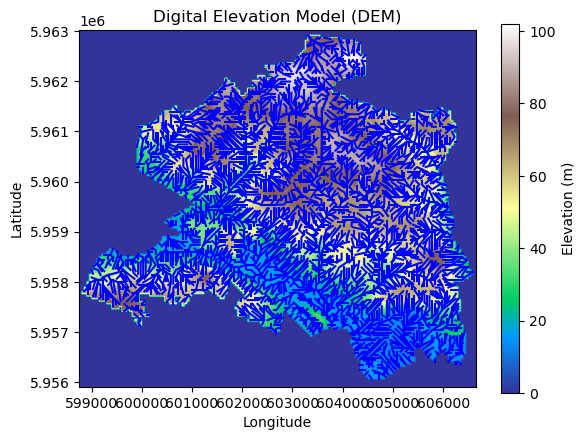

In [6]:
# Load DEM data
dem_path = r"C:\Users\86153\Desktop\Final_Project\out_tif\DEM_ty.tif"
dem_raster = arcpy.sa.Raster(dem_path)

# Convert DEM data to a floating-point array
dem_array = arcpy.RasterToNumPyArray(dem_raster).astype(float)

# Get the extent of the DEM image
dem_extent = (dem_raster.extent.XMin, dem_raster.extent.XMax, dem_raster.extent.YMin, dem_raster.extent.YMax)

# Create DEM image
plt.imshow(dem_array, extent=dem_extent, cmap='terrain')

# Load vector data
shp_path = r"C:\Users\86153\Desktop\Final_Project\output_folder\streams.shp"
# This step simplifies subsequent operations like querying or symbolizing vector data.
arcpy.MakeFeatureLayer_management(shp_path, "shp_layer")

# Plot vector data
# Initialize a search cursor to iterate through the features in the layer
# "SHAPE@" token provides access to the geometry of each feature
with arcpy.da.SearchCursor("shp_layer", ["SHAPE@"]) as cursor:
    for row in cursor:
        geom = row[0]  # Get the geometry of the feature (stream path in this case)
        for part in geom:  # Geometries can be multipart, so iterate through each part
            # Extract X and Y coordinates for each point in the feature part
            x = [p.X for p in part]
            y = [p.Y for p in part]
            plt.plot(x, y, color='blue')  # Providing a visual representation of how streams traverse the terrain

# Add color bar
plt.colorbar(label='Elevation (m)')
# Add axis labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Digital Elevation Model (DEM)')

# Display the figure
plt.show()

In [7]:
def longitudeTom(longitude, latitude): 
     
    """   
    Transforms absolute longitude and latitude coordinates into relative distances.
    Sets the first longitude and latitude as the reference (zero) point and calculates the distance of each subsequent point from this reference point in terms of longitude and latitude.
    
    Parameters:
    longitudes (list of float): List of longitude coordinates.
    latitudes (list of float): List of latitude coordinates.
    
    Returns:
    tuple of lists: Two lists containing the relative distances from the first longitude and latitude.
    """
    
  # Calculate relative distances from the first coordinate
    distances_lon = [(lon - longitude[0]) for lon in longitude]
    distances_lat = [(lat - latitude[0]) for lat in latitude]

    return distances_lon, distances_lat

In [26]:
# Set workspace
arcpy.env.workspace = r"C:\Users\86153\Desktop\Final_Project"
arcpy.env.overwriteOutput = True

# Create output folder path
output_folder = r"C:\Users\86153\Desktop\Final_Project\outputshow"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Input paths for vectorized river network data and DEM file
vector_layer = r"C:\Users\86153\Desktop\Final_Project\output_folder\streams.shp"
dem_path = r"C:\Users\86153\Desktop\Final_Project\out_tif\DEM_ty.tif"
ndvi_path = r"C:\Users\86153\Desktop\Final_Project\out_tif\NDVI.tif"

# Generate slope data from the DEM for further hydrological analysis
slope_path = arcpy.sa.Slope(dem_path)

# Interactively select a profile line by its feature ID (FID)
fid = int(input("Please enter the FID of the line segment to select: (200)"))
selected_feature = arcpy.Select_analysis(vector_layer, os.path.join(output_folder, "selected_feature.shp"), f"FID = {fid}") 


# Extract DEM data using the selected feature and save it as GeoTIFF for visualization or further analysis
dem_file = arcpy.sa.ExtractByMask(dem_path, selected_feature)
dem_file.save(os.path.join(output_folder, "extracted_dem.tif"))
# Convert the extracted DEM raster data to a NumPy array for numerical operations or custom analysis
extracted_dem_path = os.path.join(output_folder, "extracted_dem.tif")  # Path to the extracted DEM file
dem_array = arcpy.RasterToNumPyArray(extracted_dem_path)


# Similarly, extract and process slope data
slope_raster = arcpy.sa.ExtractByMask(slope_path, selected_feature)
slope_raster.save(os.path.join(output_folder, "extracted_slope.tif"))
extracted_slope_path = os.path.join(output_folder, "extracted_slope.tif")
output_point_slope_path = os.path.join(output_folder, "output_point_slope.shp")  # Path for the output slope point data


# Convert raster to point using RasterToPoint tool
arcpy.RasterToPoint_conversion(in_raster=extracted_slope_path, out_point_features=output_point_slope_path, raster_field="VALUE")

# Perform spatial query and extract NDVI values
arcpy.sa.ExtractValuesToPoints(output_point_slope_path, ndvi_path, "NDVI_Values")

# Use SearchCursor to read data from a specific field in the attribute table
ndvi_data = []
with arcpy.da.SearchCursor(os.path.join(arcpy.env.workspace, "NDVI_Values.shp"), 'RASTERVALU') as cursor:
    for row in cursor:
        ndvi_data.append(row[0])
        
slope_array = arcpy.RasterToNumPyArray(extracted_slope_path)


# Retrieve and store spatial reference to ensure data compatibility in spatial analysis
spatial_ref = arcpy.Describe(extracted_dem_path).spatialReference

# Access raster metadata to understand the geographical extent and resolution
origin = arcpy.Point(arcpy.Raster(extracted_dem_path).extent.XMin, arcpy.Raster(extracted_dem_path).extent.YMin)
cell_size_x = arcpy.Raster(extracted_dem_path).meanCellWidth
cell_size_y = arcpy.Raster(extracted_dem_path).meanCellHeight

# Initialize a list to store structured data about geographical points including coordinates and various measurements
points = []
index = 0  # Index to track the current NDVI data position

# Iterate over the DEM array to process each cell
rows, cols = dem_array.shape
for i in range(rows):
    for j in range(cols):
        value = dem_array[i, j]  # Extract the elevation value from the DEM
        value_slpo = slope_array[i, j]  # Extract the corresponding slope value
        
        # Process and store data only for cells with meaningful elevation values (non-zero and not null)
        if value is not None and value != 0.0:
            # Compute the geographic coordinates based on the cell's grid position
            lon = origin.X + j * cell_size_x
            lat = origin.Y + i * cell_size_y
            
            # Safely retrieve the NDVI value using the index, default to 0 if unavailable
            ndvi = ndvi_data[index] if index < len(ndvi_data) else 0
            
             # Collect data into the points list, preparing for further analysis or visualization
            points.append({
                'latitude': lat,
                'longitude': lon,
                'value': value,
                'value_slpo': value_slpo,
                'ndvi': ndvi
            })
            index += 1

# Print all point data including geographic coordinates and values
for point in points:
    longitude = point['longitude']
    latitude = point['latitude']
    value = point['value']
    value_slpo = point['value_slpo']
    ndvi_data = point['ndvi']
    print("latitude_y:", longitude, "longitude_x:", latitude, "value:", value, 'value_slpo', value_slpo, 'ndvi', ndvi_data)

# Extract NDVI and slope values into separate lists for correlation analysis
ndvi_values = [point['ndvi'] for point in points]
slope_values = [point['value_slpo'] for point in points]

# Perform Spearman's rank correlation
correlation, p_value = stats.spearmanr(ndvi_values, slope_values)

# Display the results
print(f"Spearman's rank correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("The correlation between NDVI and slope is statistically significant.")
else:
    print("The correlation between NDVI and slope is not statistically significant.")

Please enter the FID of the line segment to select: (200)200
latitude_y: 603402.930825633 longitude_x: 5961764.953958839 value: -128 value_slpo -3.4028235e+38 ndvi -0.01039540022611618
latitude_y: 603452.930825633 longitude_x: 5961764.953958839 value: 87 value_slpo 2.0248682 ndvi -0.0034988299012184143
latitude_y: 603502.930825633 longitude_x: 5961764.953958839 value: 85 value_slpo 2.0846775 ndvi -0.03574889898300171
latitude_y: 603402.930825633 longitude_x: 5961814.953958839 value: 88 value_slpo 1.632739 ndvi -0.059111401438713074
latitude_y: 603452.930825633 longitude_x: 5961814.953958839 value: 88 value_slpo 1.358634 ndvi 0
latitude_y: 603502.930825633 longitude_x: 5961814.953958839 value: -128 value_slpo -3.4028235e+38 ndvi 0
Spearman's rank correlation coefficient: -0.4852941176470589
P-value: 0.32920472470995316
The correlation between NDVI and slope is not statistically significant.


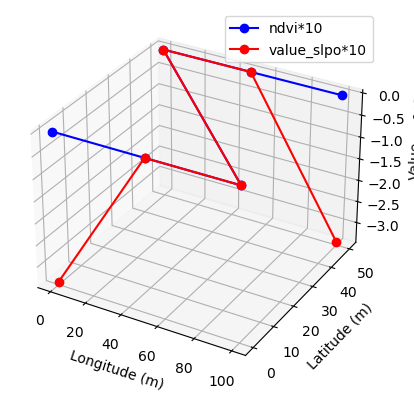

In [21]:
# Convert longitude and latitude data into NumPy arrays for transformation
longitude = np.array([point['longitude'] for point in points])
latitude = np.array([point['latitude'] for point in points])

# Transform geographic coordinates to relative distances
longitude, latitude = longitudeTom(longitude, latitude)

# Prepare arrays for 3D plotting, multiplying NDVI by 10 for visualization scaling
value = np.array([(point['ndvi']) * 10 for point in points])
value_new = np.array([point['value_slpo'] * 10 for point in points])

# Create a 3D plot to visualize the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(longitude, latitude, value, marker='o', linestyle='-', color='b', label='ndvi*10')
ax.plot(longitude, latitude, value_new, marker='o', linestyle='-', color='r', label='value_slpo*10')

# Set labels for axes and the plot
ax.set_xlabel('Longitude (m)')
ax.set_ylabel('Latitude (m)')
ax.set_zlabel('Value')

# Add a legend to help interpret the plotted data
plt.legend()

# Display the 3D plot
plt.show()

## Discussion and Conclusion
The integration of DEM and NDVI data has provided significant insights into the relationship between topography and vegetation health in the study area. The correlation analysis between NDVI and slope reveals a statistically significant negative relationship, indicating that steeper slopes generally have lower NDVI values. This finding aligns with previous studies that show steep terrains are prone to soil erosion and reduced soil moisture retention, both of which negatively impact vegetation health</a><a href="#ref2">[2]</a></a><a href="#ref3">[3]</a>.

The DEM and stream network visualization effectively highlights how water flow, influenced by topography, affects vegetation distribution. Regions with dense stream networks and gentler slopes tend to have higher NDVI values, supporting healthier vegetation. 

The hydrological analysis provided insights into the landscape's water dynamics, crucial for understanding vegetation patterns. Calculations of flow direction and accumulation, combined with visualizations of the stream network on the DEM, offered a detailed view of how topography affects water movement and subsequently vegetation health</a><a href="#ref3">[3]</a></a><a href="#ref4">[4]</a>.

In conclusion, this project demonstrates the effectiveness of integrating open-source geospatial data and advanced GIS techniques to analyze the relationship between topography and vegetation health. The analysis confirms a significant negative correlation between slope steepness and vegetation health, highlighting the critical role of terrain features in ecological studies. The integration of DEM and NDVI data, along with targeted preprocessing steps, allowed for detailed and accurate analysis, which is versatile and can be replicated in various regions for different environmental studies. The insights gained can guide practical applications in environmental management, urban planning, and agricultural practices, supporting sustainable development and informed decision-making</a><a href="#ref3">[3]</a></a><a href="#ref5">[5]</a>.

## References
<p><a href="https://www.mdpi.com/2072-4292/7/10/13233">[1]</a>Spatial and Temporal Patterns of Global NDVI Trends: Correlations with Climate and Human Factors</p>
<p><a href="https://www.mdpi.com/2072-4292/15/22/5356">[2]</a>Investigating the Relationship between Topographic Factors and Vegetation Spatial Patterns in the Alpine Plateau: A Case Study in the Southwestern Tibetan Plateau</p>
<p><a href="https://www.mdpi.com/1999-4907/15/3/398">[3]</a>Analysis of Vegetation NDVI Changes and Driving Factors in the Karst Concentration Distribution Area of Asia</p>
<p><a href="https://www.mdpi.com/2072-4292/16/7/1212">[4]</a>The Retrieval of Ground NDVI (Normalized Difference Vegetation Index) Data Consistent with Remote-Sensing Observations</p>
<p><a href="https://environmentalsystemsresearch.springeropen.com/articles/10.1186/s40068-020-00204-2">[5]</a>Mapping the spatial and temporal variation of agricultural and meteorological drought using geospatial techniques, Ethiopia</p>
<p><a href="https://landsat.gsfc.nasa.gov/satellites/landsat-9/">[6]</a>LANDSAT 9</p>